In [9]:
from Utils import Metrics
import pandas as pd
import sklearn.metrics as metric
from Plot import init_style, to_pgf

In [ ]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import sklearn.metrics as metric
import matplotlib.pyplot as plt 
from collections import defaultdict
import matplotlib as mpl

def auc_scores(test_df):
    roc_scores = defaultdict(list)
    prc_scores = defaultdict(list)

    for name, frame in test_df.groupby(["Dataset", "Run"]):
        name = name[:2]
        #frame["pred_label"] = (frame.Pred >= 0.5).astype(int)
        roc_scores[name].append(metric.roc_auc_score(frame.Label, frame.Pred))

        precision, recall, _ = metric.precision_recall_curve(frame.Label, frame.Pred)

        prc_scores[name].append(metric.auc(recall, precision))
    return roc_scores, prc_scores


In [11]:

def grouped_bar(df, pal="dark", height=3.25, aspect=1.0):
    # ax = plt.figure()
    g = sns.catplot(
        data=df, kind="bar",
        x="variable_0", y="value",
        errorbar="se", palette=pal, alpha=.6,
        facet_kws={"despine": False}, order=["Overlap", "TF-split", "TG-split", "TFTG-split"],
        capsize=.2,
        height=height,
        aspect=aspect
    )
    plt.axhline(y = 0.5, color = 'r', linestyle = '-.', alpha=0.8) 
    plt.ylim(0, 1.05)

    g.set_xlabels("Dataset")
    g.set_ylabels("AUROC (mean)")
    # g._legend.set_title("Model")
    # sns.move_legend(
    # g, "lower center",
    # bbox_to_anchor=(.45, 0.98), ncol=3, title=None)


In [12]:
COLOR = ["#EEEFEB", "#ECCD61", "#7FA3C2", "#B88FD5"]
PATCH = [None, "oooo", None, "xxxx"]


def grouped_bar(scores):
    dataset = np.unique([x[0] for x in scores.keys()]).tolist()
    model = np.unique([x[1] for x in scores.keys()]).tolist()
    x = np.array([0 + i * 0.30 for i in range(len(model))])
    pad = np.array([0.25] * len(dataset))
    ncols = 2

    if len(model) > 3:
        pad = np.array(list(range(len(dataset))))
        pad = pad * 0.35
        ncols = len(model)/2

    print(pad)
    scores = list(scores.items())
    w = 0.25
    mlt = 0 

    fig, ax = plt.subplots()
    
    for i in range(len(dataset)):
        ii = i * len(model)
        data = scores[ii:ii+len(model)]
        stderr = [np.std(val[1], ddof=1) / np.sqrt(len(val[1])) for 
                  val in data]
        mean = [np.mean(val[1]) for val in data]
      
        p = ax.bar(x + i+ pad[i], mean, w, label=model, edgecolor="black", 
                   hatch=PATCH[:len(model)], color=COLOR[:len(model)], linewidth=0.5)
        ax.bar_label(p, labels=[f'{round(val, 1)}' for val in mean], padding=3)
        
        

    handles, labels = ax.get_legend_handles_labels()
    unique = dict(zip(labels, handles)) 
    
    ax.legend(unique.values(), unique.keys(),
                loc="upper center", ncols=ncols,
                bbox_to_anchor=(0.5, 1.15), frameon=False)
    ax.set_ylim((0, 1 + 1/5))
    xticks = [np.mean(x + i + pad[i]) for i in range(len(dataset))]
    ax.set_xticks(xticks, dataset)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel("Dataset")
    ax.set_ylabel("AUROC (mean)")


def auc_scores(test_df, groups):
    roc_scores = defaultdict(list)
    prc_scores = defaultdict(list)

    for name, frame in test_df.groupby(groups + ["Run"]):
        name = name[:-1]
        #frame["pred_label"] = (frame.Pred >= 0.5).astype(int)
        roc_scores[name].append(metric.roc_auc_score(frame.Label, frame.Pred))

        precision, recall, _ = metric.precision_recall_curve(frame.Label, frame.Pred)

        prc_scores[name].append(metric.auc(recall, precision))
    return roc_scores, prc_scores

def df_from_auc(roc, prc):
    roc = pd.DataFrame.from_dict(roc).melt()
    prc = pd.DataFrame.from_dict(prc).melt()
    roc = roc.groupby(["variable_0", "variable_1"]).agg(["mean", "sem"])
    prc = prc.groupby(["variable_0", "variable_1"]).agg(["mean", "sem"])
    df = pd.concat((roc, prc), axis=1)
    df.columns = pd.MultiIndex.from_tuples(list(zip(["ROC", "ROC", "PRC", "PRC"], ["(mean)", "(SEM)"] * 2)))
    df.index.names = ["Dataset", "Model"]
    df = df.round(3)
    return df


In [13]:
def init_style():
    plt.style.use("default")

    mpl.rcParams.update({
        "savefig.bbox": "tight",
        "pgf.texsystem": "lualatex",  # Use lualatex for LaTeX processing
        "text.usetex": True,          # Use LaTeX for text rendering
        "font.family": "serif",
        "font.size": 6,               # Base font size (adjusted smaller)
        "axes.titlesize": 8,          # Title font size (smaller)
        "axes.labelsize": 7,          # Axis labels font size (smaller)
        "xtick.labelsize": 6,         # X-axis tick label font size (smaller)
        "ytick.labelsize": 6,         # Y-axis tick label font size (smaller)
        "legend.fontsize": 6,         # Legend font size (smaller)
        "lines.linewidth": 0.9,       # Line width for plot lines (adjusted thinner)
        "lines.markersize": 3,        # Marker size (adjusted smaller)
        "hatch.linewidth": 0.4,
        # Figure size in inches (adjusted for better fitting in thesis template)
        "figure.figsize": (2.96, 2.96 * 0.8),
        "figure.dpi": 400,            # DPI for rasterized output
        "savefig.dpi": 400,           # DPI for saved figures
        "pgf.preamble": r"""
        \usepackage[utf8]{inputenc}
        \usepackage[T1]{fontenc}
        \usepackage{lmodern}
        \usepackage{siunitx}
        \usepackage{amsmath}
        """,
        "axes.grid": False,           # Disable grid for cleaner presentation
        "grid.alpha": 0.3,            # Grid transparency
        "grid.linestyle": ":",        # Grid line style
        "axes.linewidth": 0.5
    })

init_style()

# scgreat experimental

In [23]:
scgreat = Metrics("../media2/binary/scgreat")


In [24]:
scgreat.test["Dataset"] =  scgreat.test.Dataset.str.split("/").apply(lambda x: x[1])
scgreat.test["Model"] = scgreat.test.shape[0] * ["scGREAT"]

In [52]:
def performance_report(df):
    data_array = []
    index1, index2 = [], []
    col_names = ["Precision", "Recall", "F1-score", "Accuracy"]

    for name, frame in df.groupby(["Dataset", "Model"]): 
        index1.append(name[0])
        lab = frame.Label 
        prob = frame.Pred
        pred_lab = (prob >= 0.5).astype(int)
        report = pd.DataFrame.from_dict(metric.classification_report(lab, pred_lab, output_dict=True))
        metrics = report.iloc[:3, 1].to_list()
        metrics += [report["accuracy"].unique().item()]
        data_array.append(metrics)

    metric_report = pd.DataFrame(data_array, index=[index1], columns=col_names)
    metric_report = metric_report.loc[["Overlap", "TF-split", "TG-split", "TFTG-split"]]
    return metric_report


In [26]:
performance_report(scgreat.test)

Precision    Recall  F1-score  Accuracy
Overlap      0.761669  0.752819  0.757218  0.756145
TF-split     0.838781  0.633239  0.721660  0.755763
TG-split     0.737833  0.714843  0.726156  0.730423
TFTG-split   0.617171  0.651025  0.633646  0.627150

In [28]:
roc, prc = auc_scores(scgreat.test, ["Dataset", "Model"])

[0.25 0.25 0.25 0.25]


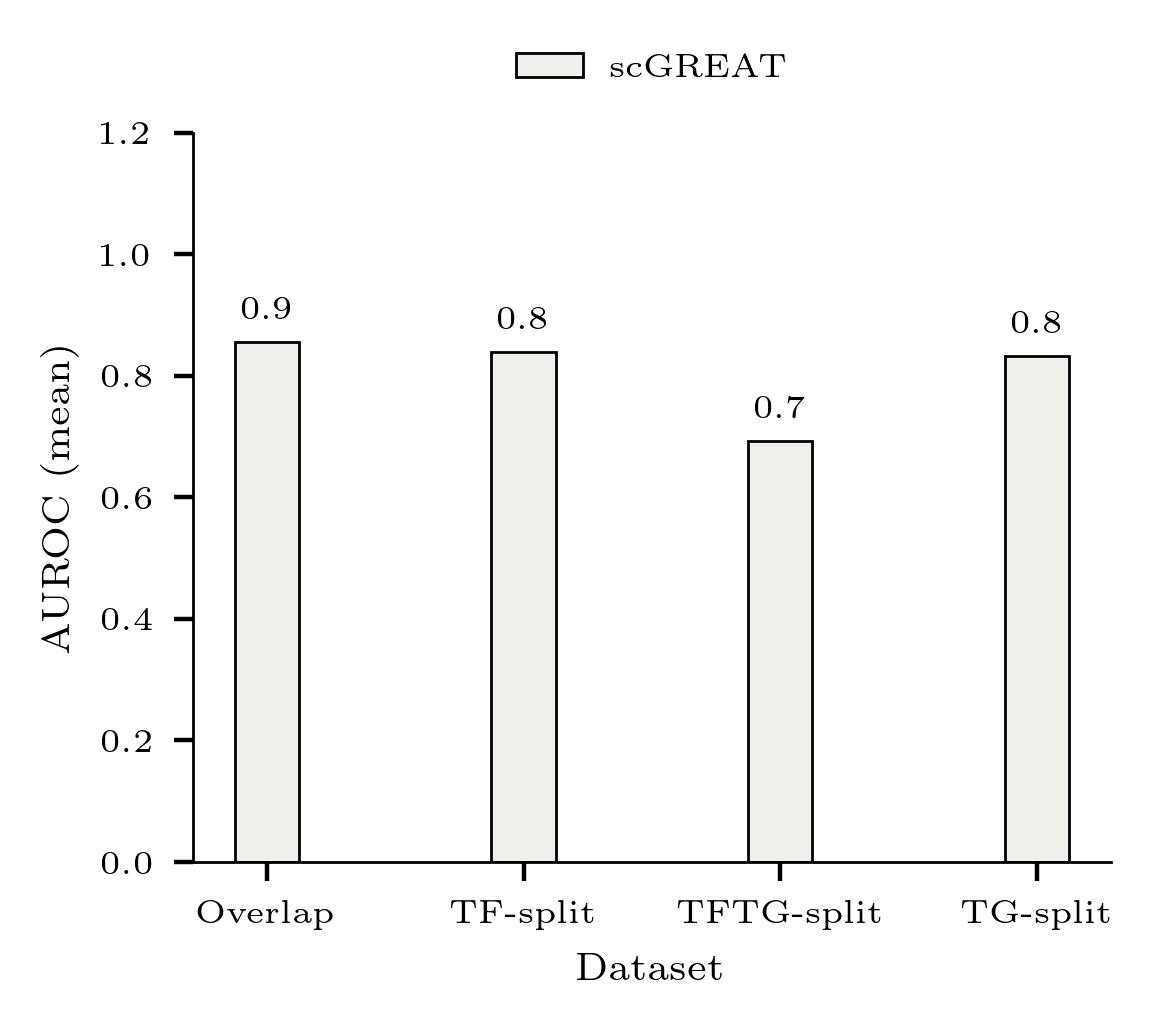

In [29]:
grouped_bar(roc)

# scGreat random 

In [38]:
scgreat_rand = Metrics("../media2/binary/scgreat/random")
scgreat_rand.test["Model"] = scgreat_rand.test.shape[0] * ["scGREAT (rand)"]
scgreat_rand.test["Dataset"] = scgreat_rand.test.Dataset.str.split("/").apply(lambda x: x[1]) 


In [39]:
performance_report(scgreat_rand.test)

Precision    Recall  F1-score  Accuracy
Overlap      0.742298  0.736304  0.739289  0.737670
TF-split     0.788013  0.617921  0.692678  0.725845
TG-split     0.729726  0.713078  0.721306  0.724485
TFTG-split   0.514548  0.593500  0.551211  0.521339

In [40]:
roc, prc = auc_scores(scgreat_rand.test, ["Dataset", "Model"])

[0.25 0.25 0.25 0.25]


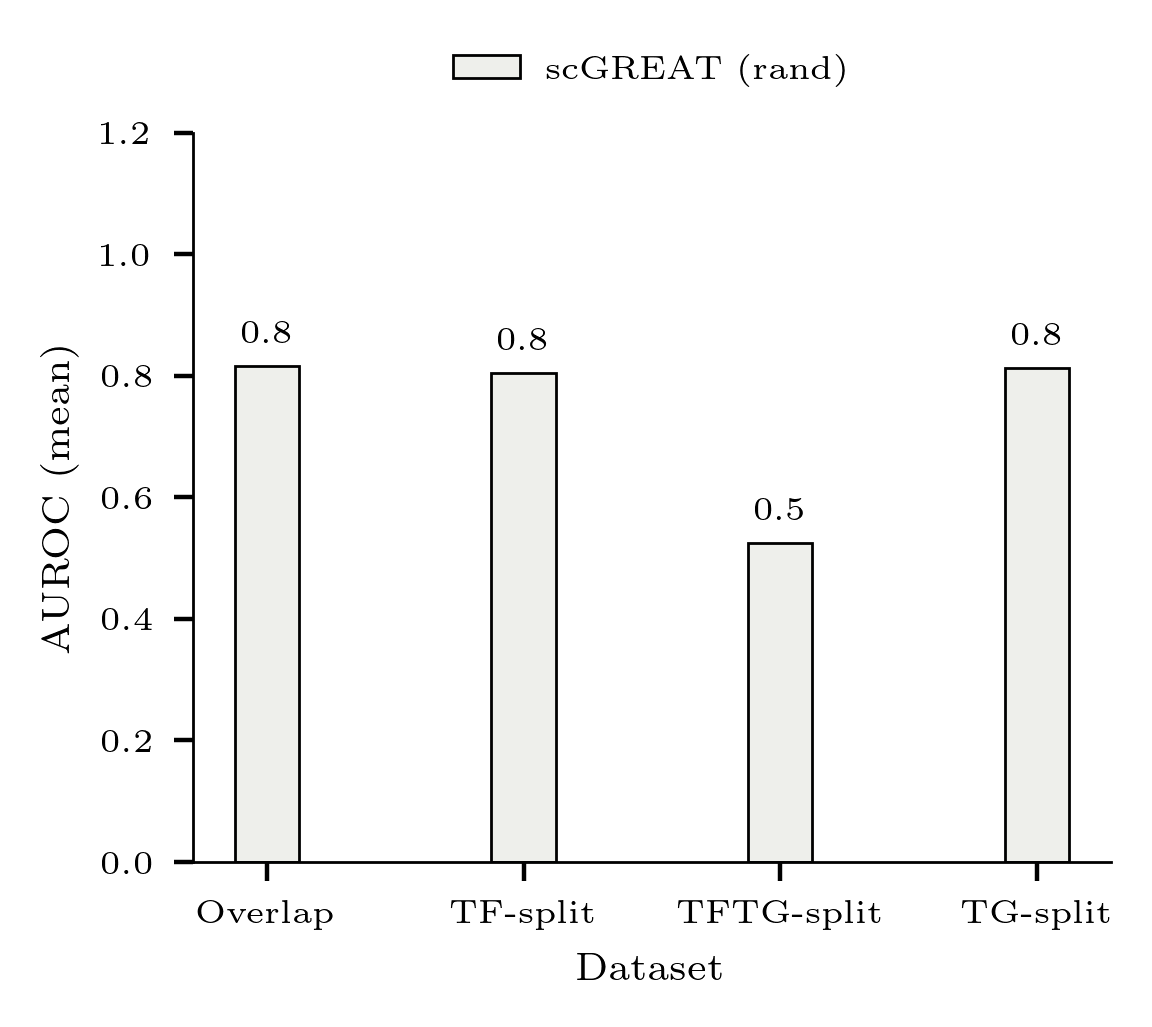

In [41]:

grouped_bar(roc)
#plt.savefig("../media2/binary/scgreat/AUROC.png", dpi=400)
#to_pgf("../media2/binary/scgreat/AUROC.pgf")

In [42]:
sc_contrast = (scgreat_rand.test, scgreat.test)
sc_contrast = pd.concat(sc_contrast)
roc, prc = auc_scores(sc_contrast, ["Dataset", "Model"])

[0.25 0.25 0.25 0.25]


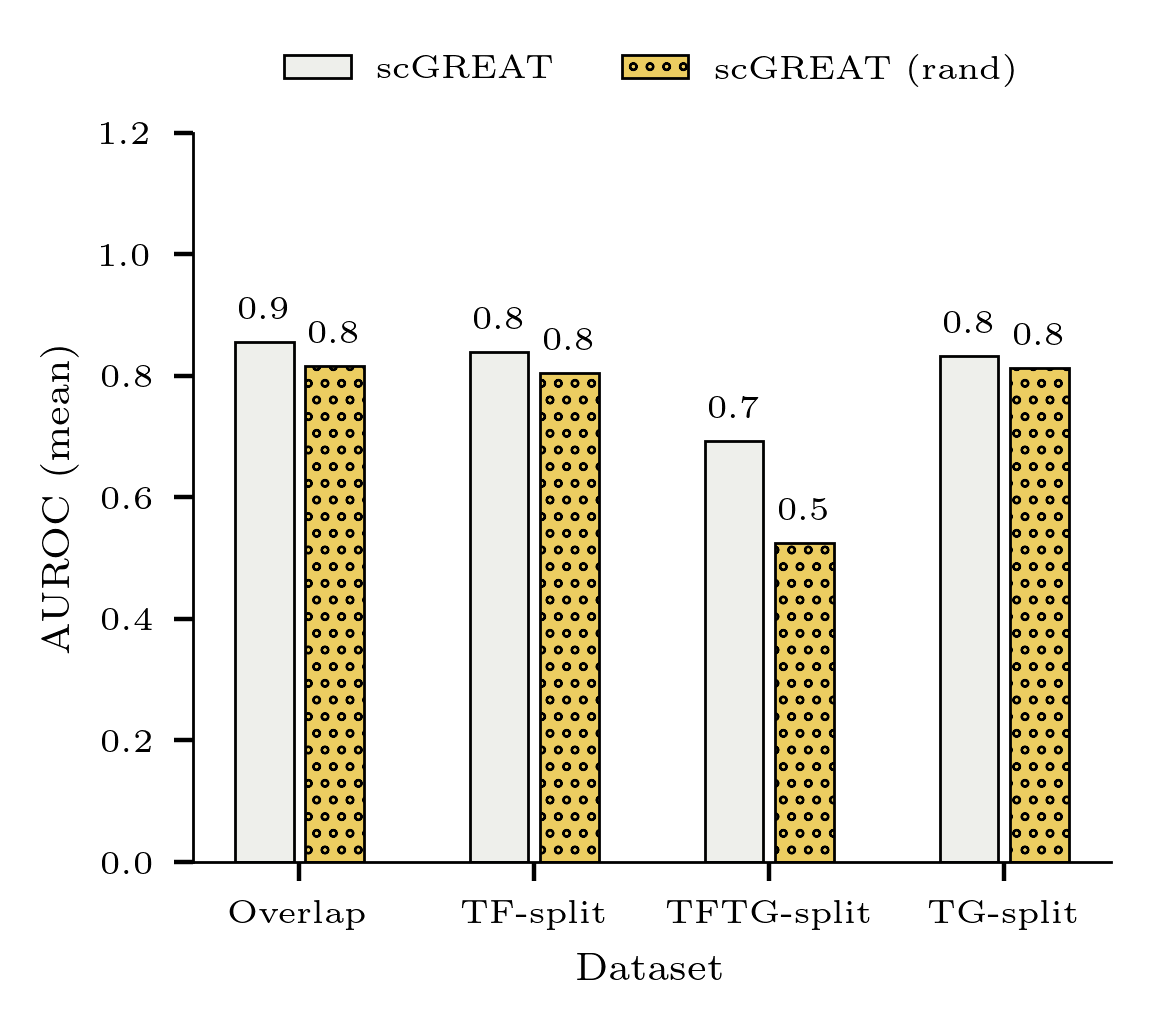

In [44]:
grouped_bar(roc)
plt.savefig(scgreat.dir.joinpath("AUROC_contrast.pdf"))

In [54]:
def performance_report(df):
    data_array = []
    index1, index2 = [], []
    col_names = ["Precision", "Recall", "F1-score", "Accuracy"]

    for name, frame in df.groupby(["Dataset", "Model"]): 
        index1.append(name[0])
        index2.append(name[1])
        lab = frame.Label 
        prob = frame.Pred
        pred_lab = (prob >= 0.5).astype(int)
        report = pd.DataFrame.from_dict(metric.classification_report(lab, pred_lab, output_dict=True))
        metrics = report.iloc[:3, 1].to_list()
        metrics += [report["accuracy"].unique().item()]
        data_array.append(metrics)

    metric_report = pd.DataFrame(data_array, index=[index1, index2], columns=col_names)
    metric_report = metric_report.loc[["Overlap", "TF-split", "TG-split", "TFTG-split"]]
    return metric_report


In [55]:
print(df_from_auc(roc, prc).to_latex(float_format="%.3f"))

\begin{tabular}{llrrrr}
\toprule
 &  & \multicolumn{2}{r}{ROC} & \multicolumn{2}{r}{PRC} \\
 &  & (mean) & (SEM) & (mean) & (SEM) \\
Dataset & Model &  &  &  &  \\
\midrule
\multirow[t]{2}{*}{Overlap} & scGREAT & 0.855 & 0.002 & 0.872 & 0.003 \\
 & scGREAT (rand) & 0.817 & 0.005 & 0.832 & 0.005 \\
\cline{1-6}
\multirow[t]{2}{*}{TF-split} & scGREAT & 0.839 & 0.007 & 0.864 & 0.007 \\
 & scGREAT (rand) & 0.804 & 0.006 & 0.819 & 0.007 \\
\cline{1-6}
\multirow[t]{2}{*}{TFTG-split} & scGREAT & 0.693 & 0.007 & 0.725 & 0.009 \\
 & scGREAT (rand) & 0.524 & 0.001 & 0.513 & 0.004 \\
\cline{1-6}
\multirow[t]{2}{*}{TG-split} & scGREAT & 0.833 & 0.004 & 0.858 & 0.004 \\
 & scGREAT (rand) & 0.812 & 0.005 & 0.835 & 0.006 \\
\cline{1-6}
\bottomrule
\end{tabular}



In [58]:
print(performance_report(sc_contrast).to_latex(float_format="%.3f"))

\begin{tabular}{llrrrr}
\toprule
 &  & Precision & Recall & F1-score & Accuracy \\
\midrule
\multirow[t]{2}{*}{Overlap} & scGREAT & 0.762 & 0.753 & 0.757 & 0.756 \\
 & scGREAT (rand) & 0.742 & 0.736 & 0.739 & 0.738 \\
\cline{1-6}
\multirow[t]{2}{*}{TF-split} & scGREAT & 0.839 & 0.633 & 0.722 & 0.756 \\
 & scGREAT (rand) & 0.788 & 0.618 & 0.693 & 0.726 \\
\cline{1-6}
\multirow[t]{2}{*}{TG-split} & scGREAT & 0.738 & 0.715 & 0.726 & 0.730 \\
 & scGREAT (rand) & 0.730 & 0.713 & 0.721 & 0.724 \\
\cline{1-6}
\multirow[t]{2}{*}{TFTG-split} & scGREAT & 0.617 & 0.651 & 0.634 & 0.627 \\
 & scGREAT (rand) & 0.515 & 0.593 & 0.551 & 0.521 \\
\cline{1-6}
\bottomrule
\end{tabular}



# network 

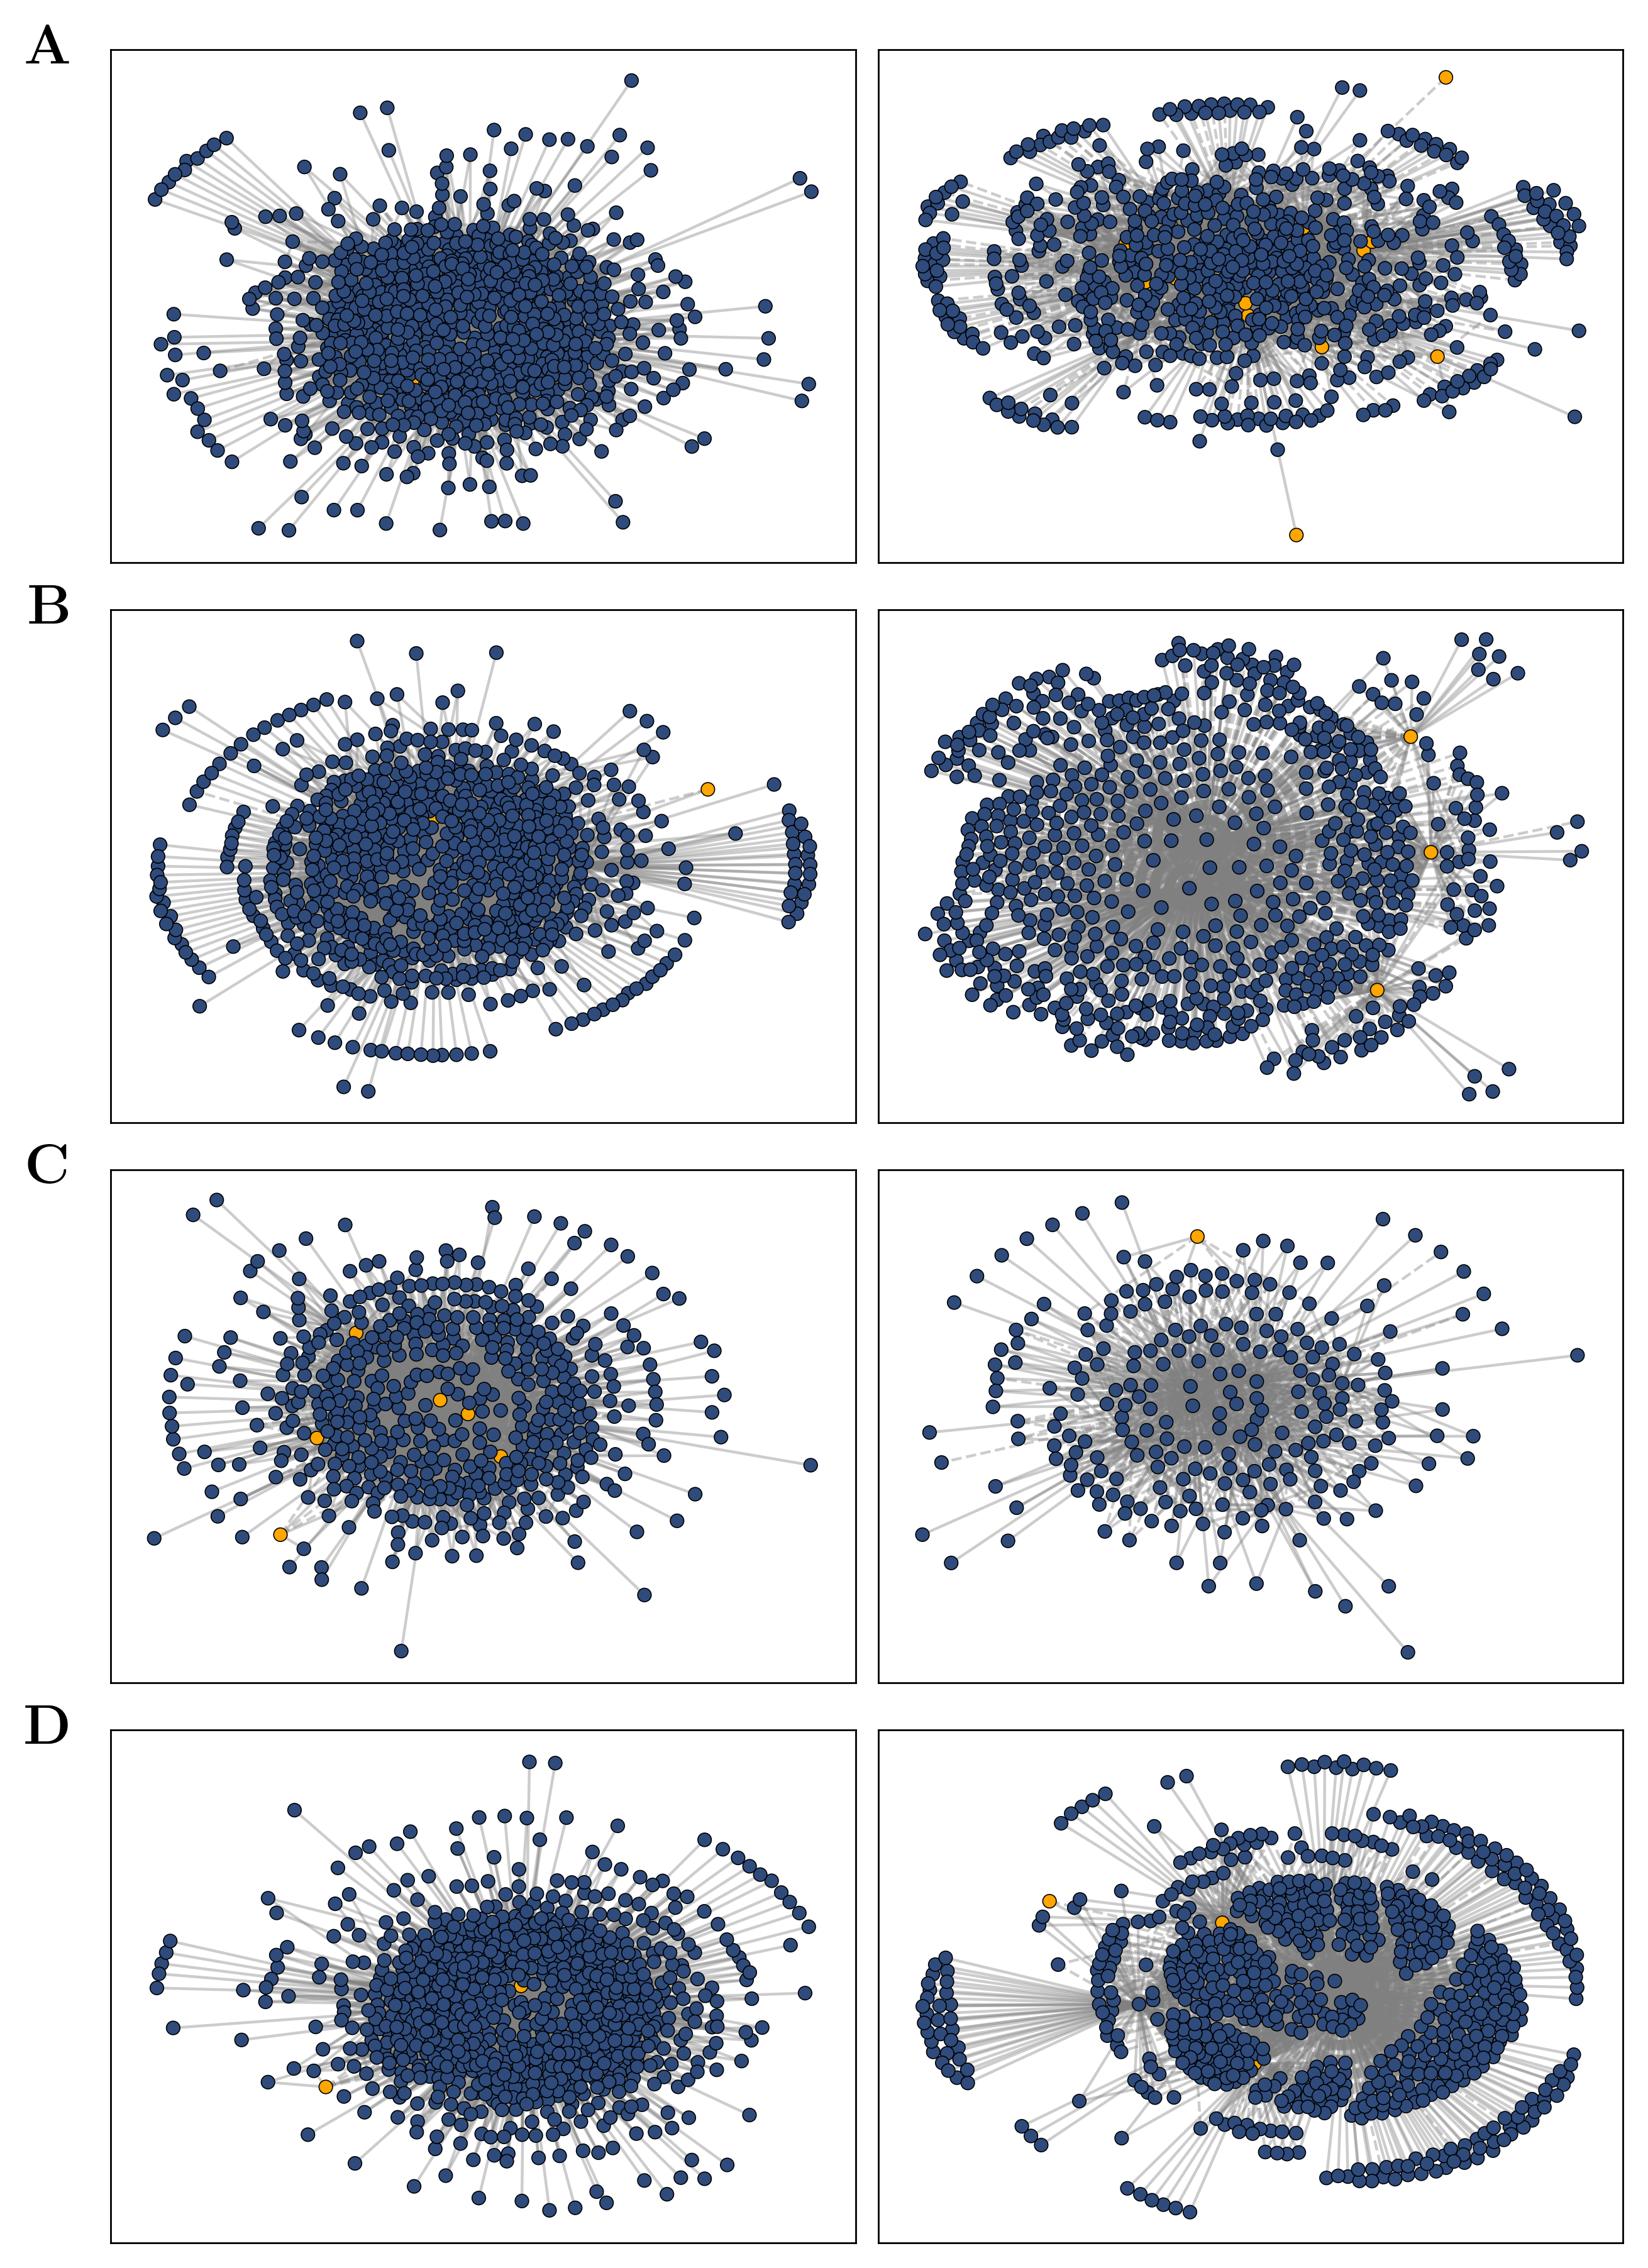

In [42]:
import os
import matplotlib.patches as mpatches
f_patch = mpatches.Patch(color='#ffa600', label='TF Nodes')
target_patch = mpatches.Patch(color='#2f4b7c', label='Target Nodes')

os.chdir("../WangyuchenCS-scGREAT-ec4cec6")

idx_files = { 
    "Overlap": "Datasets/Overlap",
    "TF-split": "Datasets/TF-split",
    "TFTG-split": "Datasets/TFTG-split",
    "TG-split": "Datasets/TG-split"
}

import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

def network(file, train=True):
    G = nx.Graph()  # Use DiGraph for directed arrows
    if train:
        dftrain = pd.read_table(Path(file).joinpath("Train_set.csv"), index_col=0, sep=",")
        for lab in [0, 1]:
            net = dftrain.loc[dftrain["Label"] == lab]
            edge_style = "dashed" if lab == 0 else "solid"  # Dashed for lab=0
            G.add_nodes_from([(node, {"color": "#ffa600"}) for node in net.TF.tolist()])
            G.add_nodes_from([(node, {"color": "#2f4b7c"}) for node in net.Target.tolist()])
            G.add_edges_from([(tf, tg, {"color": "grey", "style": edge_style}) for tf, tg in net[["TF", "Target"]].values])
    if not train:
        dftest = pd.read_table(Path(file).joinpath("Test_set.csv"), index_col=0, sep=",")
        for lab in [0, 1]:
            net = dftest.loc[dftest["Label"] == lab]
            edge_style = "dashed" if lab == 0 else "solid"
            G.add_nodes_from([(node, {"color": "#ffa600"}) for node in net.TF.tolist()])
            G.add_nodes_from([(node, {"color": "#2f4b7c"}) for node in net.Target.tolist()])
            G.add_edges_from([(tf, tg, {"color": "grey", "style": edge_style}) for tf, tg in net[["TF", "Target"]].values])

    return G

def plot_graph(G, ax):
    pos = nx.nx_agraph.graphviz_layout(G, prog="sfdp")

    node_colors = [G.nodes[node]["color"] for node in G.nodes]
    edge_colors = [G.edges[edge]["color"] for edge in G.edges]
    edge_styles = [G.edges[edge]["style"] for edge in G.edges]

    for edge, style, color in zip(G.edges, edge_styles, edge_colors):
        nx.draw_networkx_edges(G, pos, edgelist=[edge], edge_color=color, style=style, alpha=0.4, width=0.8, ax=ax)
    
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=15, edgecolors="black", alpha=1, linewidths=0.3, ax=ax)
    


fig, ax = plt.subplots(4, 2, figsize=(6.5, 9))
labels = [r"\textbf{A}", r"\textbf{B}", r"\textbf{C}", r"\textbf{D}"]
for i in range(4):
    file = idx_files[list(idx_files.keys())[i]]
    graph = network(file, train=True)
    plot_graph(graph, ax[i, 0])
    graph = network(file, train=False)
    plot_graph(graph, ax[i, 1])
    ax[i, 0].set_xticks([])
    ax[i, 1].set_xticks([])   # Remove x-axis ticks
    ax[i, 0].set_yticks([]) 
    ax[i, 1].set_yticks([])
    ax[i, 0].annotate(labels[i],
                      xy=(-0.05, 1.0),
                      xycoords='axes fraction',
                      fontsize=16,
                      fontweight='bold',
                      va='center',
                      ha='right')

fig.set_facecolor("white")  # Set plot area background to white
plt.tight_layout() 
plt.savefig("../media2/binary/scgreat/scgreat_network.pdf")
to_pgf("../media2/binary/scgreat/scgreat_network.pgf")
